# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.mobility_partitioner import MobilityPartitioner
from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.kdtree_partitioner import KDTreePartition
from pysparkmeos.partitions.adaptive_partitioner import AdaptiveBinsPartitioner
from pysparkmeos.partitions.approx_adaptive_partitioner import ApproximateAdaptiveBinsPartitioner
from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.utils.utils import *
from pysparkmeos.UDF.udf import *
from pysparkmeos.UDTF.base_partition_udtf import *

from typing import *
from time import time

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/04 10:26:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [3]:
# Read data from a CSV file
#data_path = "../../small_mid_states_2022-06-27-00.csv"  # Update this with your CSV file path
#data_path = "../../sample.csv"
#data_path = "../../filtered_sample.csv"
data_path = "../../mini_filtered_states_2022-06-27-00.csv"
data_path = "../../small_mid_states_2022-06-27-00.csv"

df = spark.read.csv(
    data_path, 
    header=True, 
    inferSchema=True, 
    mode='PERMISSIVE'
).select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

df.show(3)

+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
|icao24|               time|  lat|   lon|               Point|     x|    y|                  t| id|
+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
|34718e|2022-06-27 00:00:00|40.87|  1.92|POINT(1.92 40.87)...|  1.92|40.87|2022-06-27 00:00:00|  0|
|ac6364|2022-06-27 00:00:00|33.14|-85.53|POINT(-85.53 33.1...|-85.53|33.14|2022-06-27 00:00:00|  1|
|406471|2022-06-27 00:00:00|51.91|  1.84|POINT(1.84 51.91)...|  1.84|51.91|2022-06-27 00:00:00|  2|
+------+-------------------+-----+------+--------------------+------+-----+-------------------+---+
only showing top 3 rows



Handling a dataset like this gives us granularity over the datapoints, but it would be better to group the trajectories together using another function, this will return the TGeogPointSeq objects representing each trajectory. Let's create a UDTF that takes the icao24, and Point, and creates a new table with icao24, and PointSeq.

In [4]:
print("Total row Point count: ", df.count())

df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", tgeompointseq_from_instant_list("PointSeq"))


print("Total row PointSeq count after processing: ", trajectories.count())

trajectories.show(5)

Total row Point count:  23288


+------+---+
|icao24|cnt|
+------+---+
|406471|  6|
|34718e|  6|
|a04417|  6|
|ac6364|  6|
|a054e1|  5|
|a51b96|  5|
|a6cf94|  5|
|7c7aac|  5|
|a95c2f|  5|
|c05ee5|  5|
|3455d9|  5|
|ac7ac9|  5|
|ad60b7|  5|
|4952a5|  5|
|a77ae0|  5|
|a0c4a1|  5|
|8013d8|  5|
|a03cb6|  5|
|700024|  5|
|740736|  5|
+------+---+
only showing top 20 rows



Total row PointSeq count after processing:  5187


+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|0100f6|[POINT(24.76 35.7...|
|010109|[POINT(51.27 26.4...|
|01013d|[POINT(10.56 46.3...|
|0101a7|[POINT(12.12 43.6...|
|0101bb|[POINT(51.63 25.1...|
+------+--------------------+
only showing top 5 rows



This has reduced the table from individual Points to much less sequences PointSeq!

Now we need to calculate the boundaries of the whole space of trajectories.

In [5]:
trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show()
trajectories.cache()
print(trajectories.count())

+------+--------------------+--------------------+-----+
|icao24|            PointSeq|               STBox|seqId|
+------+--------------------+--------------------+-----+
|0100f6|[POINT(24.76 35.7...|STBOX XT(((24.76,...|    0|
|010109|[POINT(51.27 26.4...|STBOX XT(((51.2,2...|    1|
|01013d|[POINT(10.56 46.3...|STBOX XT(((10.56,...|    2|
|0101a7|[POINT(12.12 43.6...|STBOX XT(((12.12,...|    3|
|0101bb|[POINT(51.63 25.1...|STBOX XT(((51.63,...|    4|
|0101bd|[POINT(46.74 24.8...|STBOX XT(((46.74,...|    5|
|0101dd|[POINT(55.51 25.0...|STBOX XT(((55.51,...|    6|
|010205|[POINT(13.54 42.7...|STBOX XT(((13.54,...|    7|
|010207|[POINT(26.72 35.6...|STBOX XT(((26.72,...|    8|
|01020b|[POINT(30.58 38.5...|STBOX XT(((30.57,...|    9|
|01022e|[POINT(19.73 40.8...|STBOX XT(((19.69,...|   10|
|017073|[POINT(120.85 14....|STBOX XT(((120.85...|   11|
|01802e|[POINT(29.68 39.3...|STBOX XT(((29.68,...|   12|
|02006f|[POINT(-1.74 37.8...|STBOX XT(((-1.74,...|   13|
|02009f|[POINT(-7.19 33.3...|ST

5187


In [6]:
# We use the helper functions from utils to mapReduce the bounds of the whole dataset.
bounds = trajectories.rdd.mapPartitions(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds

STBoxWrap(STBOX XT(((-177.03,-46.42),(177.4,65.76)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:50+00]))

## Generate the partitioning scheme and repartition data

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

/tmp/ipykernel_74911/913829029.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [128]:
# Regular Grid
start = time()
gp = GridPartition(cells_per_side=4, bounds=bounds)
grid = gp.as_spark_table()
grid.cache()
print("Regular Grid Partitioning PySpark Table")
grid.show()
grid.createOrReplaceTempView("RegularGrid")
end = time()
print(f"{end-start} seconds to process and create Regular Grid.")

start = time()
# KDTree
pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').collect()] #  Take real sample if datasize is too big
gpkd = KDTreePartition(moving_objects=pointsample, dimensions=['x', 'y', 't'], bounds=bounds, max_depth=4)
gridkd = gpkd.as_spark_table()
gridkd.cache()
print("KD Tree Partitioning PySpark Table")
gridkd.show()
gridkd.createOrReplaceTempView("KDTree")
end = time()
print(f"{end-start} seconds to process and create KD Tree Grid.")


# Adaptive
start = time()
pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').collect()]
agp = AdaptiveBinsPartitioner(bounds=bounds, movingobjects=pointsample, num_tiles=4, dimensions=['x', 'y', 't'], utc="UTC")
gridagp = agp.as_spark_table()
gridagp.cache()
print("Adaptive Bins Partitioning PySpark Table")
gridagp.show()
gridagp.createOrReplaceTempView("AdaptiveBins")
end = time()
print(f"{end-start} seconds to process and create Adaptive Bins Grid.")

# Approximate Adaptive
start = time()
agp2 = ApproximateAdaptiveBinsPartitioner(df=trajectories, colname='PointSeq', bounds=bounds, num_tiles=4, dimensions=['x', 'y', 't'], utc="UTC")
gridagp2 = agp2.as_spark_table()
gridagp2.cache()
print("Approximate Adaptive Bins Partitioning PySpark Table")
gridagp2.show(truncate=False)
gridagp2.createOrReplaceTempView("ApproximateAdaptiveBins")
end = time()
print(f"{end-start} seconds to process and create Approximate Adaptive Bins Grid.")

24/07/05 08:21:16 WARN CacheManager: Asked to cache already cached data.


Regular Grid Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-177.0...|
|     1|STBOX XT(((-177.0...|
|     2|STBOX XT(((-177.0...|
|     3|STBOX XT(((-177.0...|
|     4|STBOX XT(((-177.0...|
|     5|STBOX XT(((-177.0...|
|     6|STBOX XT(((-177.0...|
|     7|STBOX XT(((-177.0...|
|     8|STBOX XT(((-177.0...|
|     9|STBOX XT(((-177.0...|
|    10|STBOX XT(((-177.0...|
|    11|STBOX XT(((-177.0...|
|    12|STBOX XT(((-177.0...|
|    13|STBOX XT(((-177.0...|
|    14|STBOX XT(((-177.0...|
|    15|STBOX XT(((-177.0...|
|    16|STBOX XT(((-88.42...|
|    17|STBOX XT(((-88.42...|
|    18|STBOX XT(((-88.42...|
|    19|STBOX XT(((-88.42...|
+------+--------------------+
only showing top 20 rows

2.471184730529785 seconds to process and create Regular Grid.


KD Tree Partitioning PySpark Table


+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-177.0...|
|     1|STBOX XT(((-97.66...|
|     2|STBOX XT(((-177.0...|
|     3|STBOX XT(((-99.47...|
|     4|STBOX XT(((-177.0...|
|     5|STBOX XT(((-97.75...|
|     6|STBOX XT(((-177.0...|
|     7|STBOX XT(((-98.03...|
|     8|STBOX XT(((-82.55...|
|     9|STBOX XT(((75.32,...|
|    10|STBOX XT(((-82.55...|
|    11|STBOX XT(((30.8,-...|
|    12|STBOX XT(((-82.55...|
|    13|STBOX XT(((-68.46...|
|    14|STBOX XT(((-82.55...|
|    15|STBOX XT(((-3.59,...|
+------+--------------------+

10.365208387374878 seconds to process and create KD Tree Grid.


24/07/05 08:21:35 WARN CacheManager: Asked to cache already cached data.        


Adaptive Bins Partitioning PySpark Table
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-177.0...|
|     1|STBOX XT(((-98.26...|
|     2|STBOX XT(((-82.54...|
|     3|STBOX XT(((0.64,-...|
|     4|STBOX XT(((-177.0...|
|     5|STBOX XT(((-98.26...|
|     6|STBOX XT(((-82.54...|
|     7|STBOX XT(((0.64,3...|
|     8|STBOX XT(((-177.0...|
|     9|STBOX XT(((-98.26...|
|    10|STBOX XT(((-82.54...|
|    11|STBOX XT(((0.64,3...|
|    12|STBOX XT(((-177.0...|
|    13|STBOX XT(((-98.26...|
|    14|STBOX XT(((-82.54...|
|    15|STBOX XT(((0.64,4...|
|    16|STBOX XT(((-177.0...|
|    17|STBOX XT(((-98.26...|
|    18|STBOX XT(((-82.54...|
|    19|STBOX XT(((0.64,-...|
+------+--------------------+
only showing top 20 rows

7.111777305603027 seconds to process and create Adaptive Bins Grid.


24/07/05 08:22:09 WARN CacheManager: Asked to cache already cached data.        


Approximate Adaptive Bins Partitioning PySpark Table
+------+---------------------------------------------------------------------------------------------+
|tileid|tile                                                                                         |
+------+---------------------------------------------------------------------------------------------+
|0     |STBOX XT(((-177.03,-46.42),(-101.22,33.11)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00])|
|1     |STBOX XT(((-101.22,-46.42),(-78.88,33.11)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00]) |
|2     |STBOX XT(((-78.88,-46.42),(4.55,33.11)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00])    |
|3     |STBOX XT(((4.55,-46.42),(177.4,33.11)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00])     |
|4     |STBOX XT(((-177.03,33.11),(-101.22,38.58)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00]) |
|5     |STBOX XT(((-101.22,33.11),(-78.88,38.58)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:30+00])  |
|6     |STBOX XT(((-

/tmp/ipykernel_74911/1921019570.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ERROR:fiona._env:PROJ: internal_proj_identify: /usr/local/lib/python3.9/dist-packages/pymeos_cffi/proj_data/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: internal_proj_identify: /usr/local/lib/python3.9/dist-packages/pymeos_cffi/proj_data/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


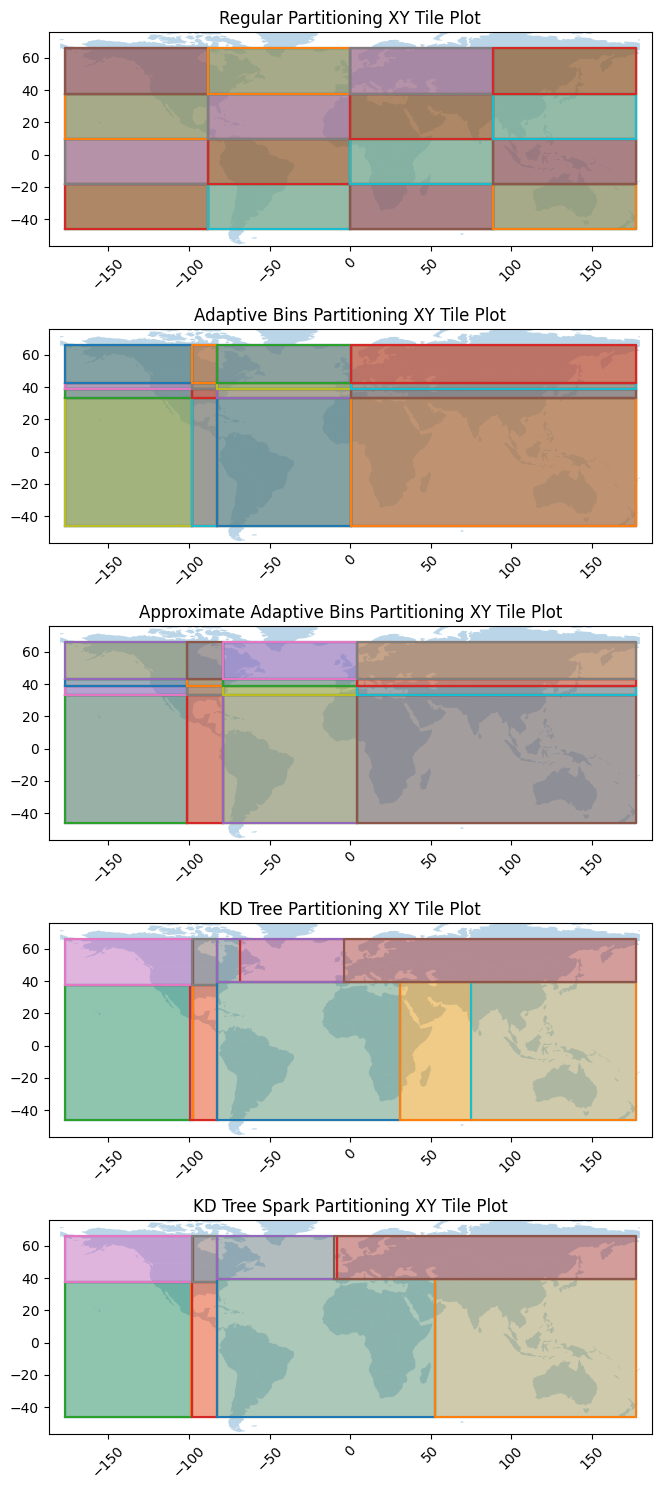

In [131]:
# Now we calculate the grid and partition accordingly
fig, ax = plt.subplots(5, 1, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)  # Increase the value to add more space

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[world['continent'] == 'North America']

minx = bounds.expand(10.0).xmin()
maxx = bounds.expand(10.0).xmax()
miny = bounds.expand(10.0).ymin()
maxy = bounds.expand(10.0).ymax()

world.plot(ax=ax[0], alpha=0.3)
world.plot(ax=ax[1], alpha=0.3)
world.plot(ax=ax[2], alpha=0.3)
world.plot(ax=ax[3], alpha=0.3)
world.plot(ax=ax[4], alpha=0.3)


gp.plot(axes=ax[0])
ax[0].title.set_text("Regular Partitioning XY Tile Plot")

agp.plot(axes=ax[1])
ax[1].title.set_text("Adaptive Bins Partitioning XY Tile Plot")

agp2.plot(axes=ax[2])
ax[2].title.set_text("Approximate Adaptive Bins Partitioning XY Tile Plot")

gpkd.plot(axes=ax[3])
ax[3].title.set_text("KD Tree Partitioning XY Tile Plot")

gpkd2.plot(axes=ax[4])
ax[4].title.set_text("KD Tree Spark Partitioning XY Tile Plot")

for i, _ in enumerate(ax):
    ax[i].set_xlim(minx, maxx)
    ax[i].set_ylim(miny, maxy)

# Adjust layout
fig.tight_layout()

# Save each subplot as an SVG file with labels
for i, axis in enumerate(ax):
    extent = axis.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'subplot_{i+1}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.show()

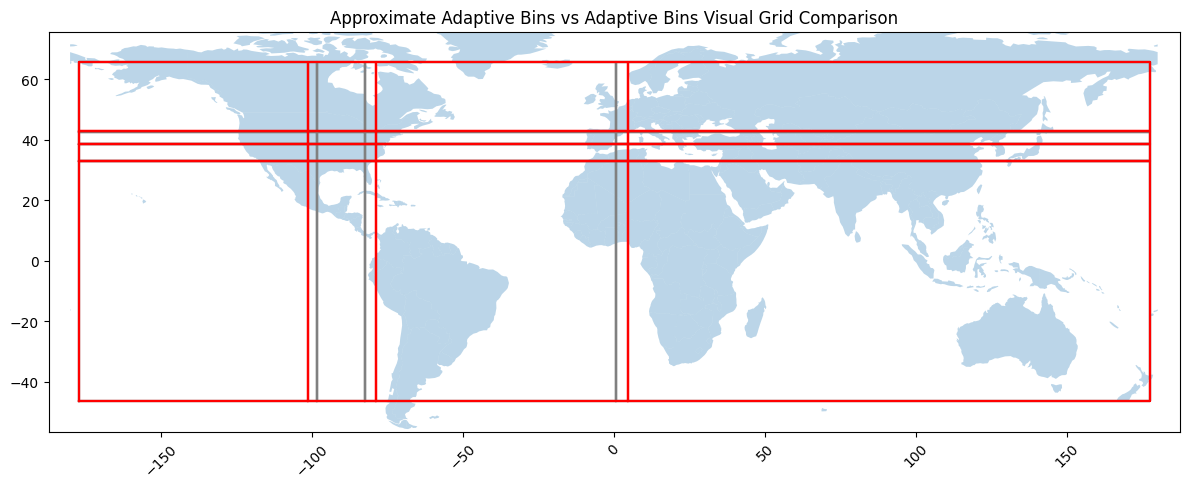

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
world.plot(ax=ax, alpha=0.3)
agp.plot(axes=ax, draw_filling=False, color='grey')
agp2.plot(axes=ax, draw_filling=False, color='red')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Adjust layout
fig.tight_layout()

# Save each subplot as an SVG file with labels
extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f'compare_bins.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

ax.title.set_text("Approximate Adaptive Bins vs Adaptive Bins Visual Grid Comparison")
plt.show()

24/07/05 20:01:37 WARN SimpleTableFunctionRegistry: The function instantsudtf replaced a previously registered function.


KD Tree Partitioning Spark Engine PySpark Table


+------+--------------------------------------------------------------------------------------------+
|tileid|tile                                                                                        |
+------+--------------------------------------------------------------------------------------------+
|0     |STBOX XT(((-177.03,-46.42),(-97.67,34.13)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00])|
|1     |STBOX XT(((-177.03,-46.42),(-97.67,34.13)),[2022-06-27 00:00:20+00, 2022-06-27 00:00:30+00])|
|2     |STBOX XT(((-177.03,34.13),(-97.67,37.8)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:10+00])  |
|3     |STBOX XT(((-177.03,34.13),(-97.67,37.8)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:30+00])  |
|4     |STBOX XT(((-97.67,-46.42),(-82.55,32.33)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00]) |
|5     |STBOX XT(((-97.67,-46.42),(-82.55,32.33)),[2022-06-27 00:00:20+00, 2022-06-27 00:00:30+00]) |
|6     |STBOX XT(((-97.67,32.33),(-82.55,37.8)),[2022-06-27 00:00:00+00, 2022-06-2

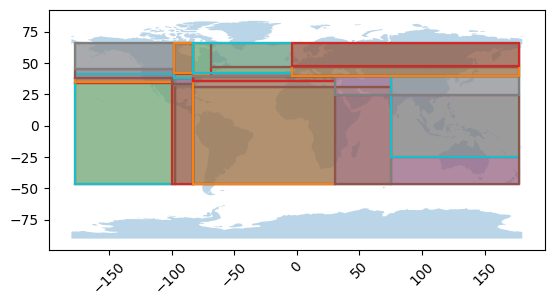

In [146]:
# KD with Map Reduce

# Materialize Instants in dataframe
@F.udtf(returnType=StructType([
    StructField("seqId", IntegerType()),
    StructField("instant", TGeomPointInstUDT()),
    StructField("x", DoubleType()),
    StructField("y", DoubleType()),
    StructField("z", DoubleType()),
    StructField("t", TimestampType())
]))
class InstantsUDTF:
    def eval(self, row, utc="UTC"):
        pymeos_initialize(utc)
        instants = row.movingobject.instants()
        for instant in instants:
            z = None
            if instant.has_z():
                z = instant.z().start_value()
            yield row.trajectory_id, TGeomPointInstWrap(instant.__str__()), instant.x().start_value(), instant.y().start_value(), z, instant.start_timestamp()

spark.udtf.register("InstantsUDTF", InstantsUDTF)

instants = spark.sql(f"""
        SELECT * 
        FROM InstantsUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id,
                        PointSeq AS movingobject
                    FROM trajectories
            )
        )
""").withColumn("rowNo", F.monotonically_increasing_id())

def map_at(rows, traj_colname, index_colname, bounds, utc):
    pymeos_initialize(utc)
    response = []
    for row in rows:
        at = row[traj_colname].at(bounds)
        if at:
            response.append((row[index_colname], row[traj_colname], row['x'], row['y'], row['t'], row['rowNo']))
    return response
    
def kdtree(instants, traj_colname, index_colname, bounds, dims, depth, max_depth, utc):
    pymeos_initialize(utc)
    dim = dims[depth % len(dims)]
    tiles = []
    
    instants_at = instants.rdd.mapPartitions(
        lambda x: map_at(x, 'instant', index_colname, bounds, utc)
    ).toDF([index_colname, traj_colname, 'x', 'y', 't', 'rowNo'])

    num_instants = instants_at.count()
    
    if depth == max_depth or num_instants <= 1:
        tiles.append(bounds)
    else:
        if dim == 't':
            instants_at = instants_at.withColumn("ts", F.unix_timestamp(dim)).orderBy("ts").withColumn('rowNo', F.monotonically_increasing_id())
            #mediandim = instants_at.agg(F.median("ts")).collect()[0]['median(ts)']
            mediandim = instants_at.approxQuantile("rowNo", [0.5], 0.0)[0]
            lower = instants_at.where(f'rowNo<={mediandim}')
            upper = instants_at.where(f'rowNo>{mediandim}')
            midrow = instants_at.where(f'rowNo={mediandim}').first()
        else:
            instants_at = instants_at.orderBy(dim).withColumn('rowNo', F.monotonically_increasing_id())
            #mediandim = instants_at.agg(F.median(dim)).collect()[0][f'median({dim})']
            mediandim = instants_at.approxQuantile("rowNo", [0.5], 0.0)[0]
            lower = instants_at.where(f'rowNo<={mediandim}')
            upper = instants_at.where(f'rowNo>{mediandim}')
            midrow = instants_at.where(f'rowNo={mediandim}').first()

        #print(f"LEVEL {depth}")
        #lower.show()
        #upper.show()
        #print(midrow)
        #print(mediandim)
        #print("----------------")
        
        bboxleft = STBoxWrap(new_bounds_from_axis(bounds, dim, midrow[traj_colname], "left").__str__())
        bboxright = STBoxWrap(new_bounds_from_axis(bounds, dim, midrow[traj_colname], "right").__str__())
        
        left = kdtree(lower, traj_colname, index_colname, bboxleft, dims, depth+1, max_depth, utc) 
        right = kdtree(upper, traj_colname, index_colname, bboxright, dims, depth+1, max_depth, utc)
        
        tiles.extend(left)
        tiles.extend(right)
        
    return tiles

start = time()
# KDTree with Spark
gpkd2 = KDTreePartition(moving_objects=pointsample, dimensions=['x', 'y', 't'], bounds=bounds, max_depth=6)
gpkd2.grid = kdtree(instants, 'instant', 'seqId', bounds, ['x', 'y', 't'], 0, 6, "UTC")
gpkd2.numPartitions = len(gpkd2.grid)
gpkd2.tilesstr = [tile.__str__() for tile in gpkd2.grid]
gridkd2 = gpkd2.as_spark_table()
gridkd2.cache()
print("KD Tree Partitioning Spark Engine PySpark Table")
gridkd2.show(truncate=False)
gridkd2.createOrReplaceTempView("KDTreeSpark")
end = time()
print(f"{end-start} seconds to process and create KD Tree Grid.")
world.plot(alpha=0.3)
gpkd2.plot()

24/07/06 07:12:34 WARN CacheManager: Asked to cache already cached data.        


KD Tree Partitioning Corrected Table
+------+--------------------------------------------------------------------------------------------+
|tileid|tile                                                                                        |
+------+--------------------------------------------------------------------------------------------+
|0     |STBOX XT(((-177.03,-46.42),(-97.66,34.13)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00])|
|1     |STBOX XT(((-177.03,-46.42),(-97.66,34.13)),[2022-06-27 00:00:20+00, 2022-06-27 00:00:30+00])|
|2     |STBOX XT(((-177.03,34.13),(-97.66,37.81)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:10+00]) |
|3     |STBOX XT(((-177.03,34.13),(-97.66,37.81)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:30+00]) |
|4     |STBOX XT(((-97.66,-46.42),(-82.55,32.33)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00]) |
|5     |STBOX XT(((-97.66,-46.42),(-82.55,32.33)),[2022-06-27 00:00:20+00, 2022-06-27 00:00:30+00]) |
|6     |STBOX XT(((-97.66,32.33),(-82.55,37.8

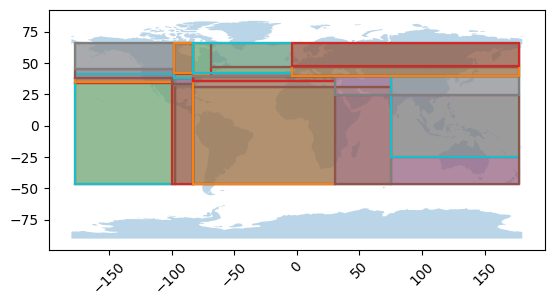

In [148]:
from pysparkmeos.partitions.mobility_partitioner import MobilityPartitioner
from pysparkmeos.utils.utils import new_bounds_from_axis, from_axis
from typing import *
from pymeos import *
from pymeos import TPoint
import numpy as np

class KDTreePartition3(MobilityPartitioner):
    def __init__(
            self,
            moving_objects: List[TPoint],
            bounds: STBox,
            dimensions: tuple,
            max_depth=12
    ):
        self.max_depth = max_depth
        self.bounds = bounds
        self.grid = self._generate_grid(bounds, moving_objects, 0, dimensions, max_depth)
        self.numPartitions = len(self.grid)
        self.tilesstr = [tile.__str__() for tile in self.grid]
        super().__init__(self.numPartitions, self.get_partition)

    @staticmethod
    def _generate_grid(
        bounds: STBox,
        movingobjects: List[TPoint],
        depth: int = 0,
        dimensions: tuple = ("x", "y", "t"),
        max_depth=12,
        utc='UTC'
    ):
        pymeos_initialize(utc)

        axis = dimensions[depth % len(dimensions)]
        tiles = []

        pointsat = [point.at(bounds) for point in movingobjects]

        # Sort by dimension
        movingobjects = sorted(movingobjects, key=lambda p: from_axis(p, axis))
        num_points = len(movingobjects)

        if depth == max_depth or num_points <= 1:
            tiles.append(bounds)
        else:
            median = movingobjects[num_points // 2]
            
            bboxleft = new_bounds_from_axis(bounds, axis, median, "left")
            bboxright = new_bounds_from_axis(bounds, axis, median, "right")

            # print("Median is ", median, " splitted by axis: ", axis)

            left = KDTreePartition._generate_grid(
                bboxleft,
                movingobjects[:num_points // 2],
                depth + 1,
                dimensions,
                max_depth,
            )
            right = KDTreePartition._generate_grid(
                bboxright,
                movingobjects[num_points // 2:],
                depth + 1,
                dimensions,
                max_depth,
            )
            
            tiles.extend(left)
            tiles.extend(right)
            
        return tiles

    def num_partitions(self) -> int:
        """Return the total number of partitions."""
        return self.numPartitions

start = time()
# KDTree Normal Updated
instsample = [traj.instant for traj in instants.select('instant').collect()] #  Take real sample if datasize is too big
gpkd3 = KDTreePartition3(moving_objects=instsample, dimensions=['x', 'y', 't'], bounds=bounds, max_depth=6)
gridkd3 = gpkd3.as_spark_table()
gridkd3.cache()
print("KD Tree Partitioning Corrected Table")
gridkd3.show(truncate=False)
gridkd3.createOrReplaceTempView("KDTreeSpark")
end = time()
print(f"{end-start} seconds to process and create KD Tree Grid.")
world.plot(alpha=0.3)
gpkd3.plot()

In [31]:
%time+

# Call the base udtf partitioner as it is useful in this usecase.
@F.udtf(returnType=partition_schema)  # Schema imported from base_partition_udtf file.
class PartitionUDTF(BasePartitionUDTF):
    def __init__(self):
        self.response_extra_cols = []
        self.check_function = None
        self.return_full_traj = False
        
    def eval(self, row: Row):
        for val in super().eval_wrap(row):
            yield val
            
spark.udtf.register("PartitionUDTF", PartitionUDTF)

def map_partition_rdd(index, rows):
    for row in rows:
        yield (row['tileid'], row)

def partition_trajectories(spark, gridname, gridclass):
    trajectoriesPartMap = spark.sql(f"""
        SELECT * 
        FROM PartitionUDTF(
            TABLE(
                    SELECT 
                        seqId AS trajectory_id, 
                        PointSeq AS movingobject, 
                        (SELECT collect_list(tile) FROM {gridname}) AS tiles, 
                        (SELECT collect_list(tileid) FROM {gridname}) AS tileids
                    FROM trajectories
            )
        )
    """)
    num_partitions = gridclass.num_partitions()
    trajectoriesPartMapRdd = trajectoriesPartMap.rdd.mapPartitionsWithIndex(map_partition_rdd).partitionBy(num_partitions)
    trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.movingobject")).withColumn("trajectoryId", F.col("trajectorydata.movingobjectid")).drop("trajectorydata")
    trajectoriesPartMap.orderBy("trajectoryId").cache()
    print(f"{gridname} Partitioned Trajectories.")
    trajectoriesPartMap.show()
    return trajectoriesPartMap, trajectoriesPartMapRdd, gridclass, gridname

partMaps = [partition_trajectories(spark, gridname, gridclass) for gridname, gridclass in zip(['RegularGrid', 'KDTree', 'AdaptiveBins', 'ApproximateAdaptiveBins'], [gp, gpkd, agp, agp2])]

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 247 µs


24/07/03 14:00:19 WARN SimpleTableFunctionRegistry: The function partitionudtf replaced a previously registered function.


RegularGrid Partitioned Trajectories.


+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|{[POINT(-113.31 3...| 163208757250|
|           0|{[POINT(-116.01 3...| 223338299392|
|           0|{[POINT(-113.28 3...| 343597383687|
|           0|{[POINT(-114.59 3...| 429496729608|
|           0|{[POINT(-114.93 3...| 833223655434|
|           0|{[POINT(-116.4 31...| 979252543492|
|           0|{[POINT(-114.28 3...|1228360646656|
|           0|{[POINT(-113.97 3...|1503238553600|
|           1|{[POINT(-114.86 3...| 137438953480|
|           1|{[POINT(-113.31 3...| 163208757250|
|           1|{[POINT(-116.01 3...| 223338299392|
|           1|{[POINT(-113.28 3...| 343597383687|
|           1|{[POINT(-114.59 3...| 429496729608|
|           1|{[POINT(-114.93 3...| 833223655434|
|           1|{[POINT(-116.4 31...| 979252543492|
|           1|{[POINT(-114.28 3...|1228360646656|
|           1|{[POINT(-113.97 3...|1503238553600|


KDTree Partitioned Trajectories.


+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.12 3...| 68719476740|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-110.2 30...|214748364802|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POINT(-113.18 3...|223338299399|
|           0|{[POINT(-117.14 3...|223338299401|
|           0|{[POIN

AdaptiveBins Partitioned Trajectories.


+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-114.86 3...|137438953480|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POINT(-113.18 3...|223338299399|
|           0|{[POINT(-117.14 3...|223338299401|
|           0|{[POINT(-112.06 3...|231928233994|
|           0|{[POIN

ApproximateAdaptiveBins Partitioned Trajectories.


+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.12 3...| 68719476740|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-114.86 3...|137438953480|
|           0|{[POINT(-111.06 2...|154618822659|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-110.2 30...|214748364802|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POIN

## Show the partition distribution

RegularGrid partition distribution.


+-----------+------------------+
|average_ppp|        stddev_ppp|
+-----------+------------------+
| 156.921875|143.88435663864735|
+-----------+------------------+

64


Partition 0 has 8 rows
Partition 1 has 9 rows
Partition 2 has 11 rows
Partition 3 has 4 rows
Partition 4 has 405 rows
Partition 5 has 412 rows
Partition 6 has 416 rows
Partition 7 has 138 rows
Partition 8 has 95 rows
Partition 9 has 100 rows
Partition 10 has 106 rows
Partition 11 has 38 rows
Partition 12 has 141 rows
Partition 13 has 141 rows
Partition 14 has 142 rows
Partition 15 has 48 rows
Partition 16 has 40 rows
Partition 17 has 41 rows
Partition 18 has 42 rows
Partition 19 has 12 rows
Partition 20 has 190 rows
Partition 21 has 193 rows
Partition 22 has 195 rows
Partition 23 has 53 rows
Partition 24 has 161 rows
Partition 25 has 163 rows
Partition 26 has 163 rows
Partition 27 has 48 rows
Partition 28 has 22 rows
Partition 29 has 22 rows
Partition 30 has 23 rows
Partition 31 has 12 rows
Partition 32 has 180 rows
Partition 33 has 185 rows
Partition 34 has 188 rows
Partition 35 has 81 rows
Partition 36 has 248 rows
Partition 37 has 258 rows
Partition 38 has 262 rows
Partition 39 has 

+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|{[POINT(-113.31 3...| 163208757250|
|           0|{[POINT(-116.01 3...| 223338299392|
|           0|{[POINT(-113.28 3...| 343597383687|
|           0|{[POINT(-114.59 3...| 429496729608|
|           0|{[POINT(-114.93 3...| 833223655434|
|           0|{[POINT(-116.4 31...| 979252543492|
|           0|{[POINT(-114.28 3...|1228360646656|
|           0|{[POINT(-113.97 3...|1503238553600|
|           1|{[POINT(-114.86 3...| 137438953480|
|           1|{[POINT(-113.31 3...| 163208757250|
|           1|{[POINT(-116.01 3...| 223338299392|
|           1|{[POINT(-113.28 3...| 343597383687|
|           1|{[POINT(-114.59 3...| 429496729608|
|           1|{[POINT(-114.93 3...| 833223655434|
|           1|{[POINT(-116.4 31...| 979252543492|
|           1|{[POINT(-114.28 3...|1228360646656|
|           1|{[POINT(-113.97 3...|1503238553600|


+-----------+-----------------+
|average_ppp|       stddev_ppp|
+-----------+-----------------+
|  158.09375|61.99327120424582|
+-----------+-----------------+

64


Partition 0 has 153 rows
Partition 1 has 158 rows
Partition 2 has 229 rows
Partition 3 has 231 rows
Partition 4 has 162 rows
Partition 5 has 165 rows
Partition 6 has 196 rows
Partition 7 has 203 rows
Partition 8 has 226 rows
Partition 9 has 77 rows
Partition 10 has 143 rows
Partition 11 has 41 rows
Partition 12 has 226 rows
Partition 13 has 84 rows
Partition 14 has 167 rows
Partition 15 has 47 rows
Partition 16 has 163 rows
Partition 17 has 168 rows
Partition 18 has 241 rows
Partition 19 has 245 rows
Partition 20 has 166 rows
Partition 21 has 168 rows
Partition 22 has 179 rows
Partition 23 has 182 rows
Partition 24 has 215 rows
Partition 25 has 75 rows
Partition 26 has 143 rows
Partition 27 has 48 rows
Partition 28 has 238 rows
Partition 29 has 69 rows
Partition 30 has 177 rows
Partition 31 has 74 rows
Partition 32 has 163 rows
Partition 33 has 170 rows
Partition 34 has 202 rows
Partition 35 has 206 rows
Partition 36 has 158 rows
Partition 37 has 164 rows
Partition 38 has 208 rows
Part

+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.12 3...| 68719476740|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-110.2 30...|214748364802|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POINT(-113.18 3...|223338299399|
|           0|{[POINT(-117.14 3...|223338299401|
|           0|{[POIN

+------------------+----------------+
|       average_ppp|      stddev_ppp|
+------------------+----------------+
|148.54166666666666|75.0262247295112|
+------------------+----------------+

48


Partition 0 has 121 rows
Partition 1 has 257 rows
Partition 2 has 180 rows
Partition 3 has 199 rows
Partition 4 has 298 rows
Partition 5 has 158 rows
Partition 6 has 132 rows
Partition 7 has 164 rows
Partition 8 has 114 rows
Partition 9 has 221 rows
Partition 10 has 195 rows
Partition 11 has 232 rows
Partition 12 has 222 rows
Partition 13 has 122 rows
Partition 14 has 252 rows
Partition 15 has 165 rows
Partition 16 has 125 rows
Partition 17 has 260 rows
Partition 18 has 185 rows
Partition 19 has 204 rows
Partition 20 has 299 rows
Partition 21 has 158 rows
Partition 22 has 138 rows
Partition 23 has 165 rows
Partition 24 has 121 rows
Partition 25 has 221 rows
Partition 26 has 194 rows
Partition 27 has 234 rows
Partition 28 has 225 rows
Partition 29 has 126 rows
Partition 30 has 256 rows
Partition 31 has 166 rows
Partition 32 has 46 rows
Partition 33 has 90 rows
Partition 34 has 60 rows
Partition 35 has 73 rows
Partition 36 has 89 rows
Partition 37 has 51 rows
Partition 38 has 47 rows
Par

+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-114.86 3...|137438953480|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POINT(-113.18 3...|223338299399|
|           0|{[POINT(-117.14 3...|223338299401|
|           0|{[POINT(-112.06 3...|231928233994|
|           0|{[POIN

+-----------+-----------------+
|average_ppp|       stddev_ppp|
+-----------+-----------------+
|     148.25|101.2251545560372|
+-----------+-----------------+

48


Partition 0 has 153 rows
Partition 1 has 176 rows
Partition 2 has 73 rows
Partition 3 has 393 rows
Partition 4 has 220 rows
Partition 5 has 127 rows
Partition 6 has 49 rows
Partition 7 has 272 rows
Partition 8 has 326 rows
Partition 9 has 173 rows
Partition 10 has 86 rows
Partition 11 has 203 rows
Partition 12 has 100 rows
Partition 13 has 216 rows
Partition 14 has 142 rows
Partition 15 has 314 rows
Partition 16 has 156 rows
Partition 17 has 182 rows
Partition 18 has 73 rows
Partition 19 has 403 rows
Partition 20 has 223 rows
Partition 21 has 128 rows
Partition 22 has 50 rows
Partition 23 has 277 rows
Partition 24 has 329 rows
Partition 25 has 176 rows
Partition 26 has 85 rows
Partition 27 has 209 rows
Partition 28 has 105 rows
Partition 29 has 216 rows
Partition 30 has 142 rows
Partition 31 has 317 rows
Partition 32 has 51 rows
Partition 33 has 64 rows
Partition 34 has 25 rows
Partition 35 has 138 rows
Partition 36 has 77 rows
Partition 37 has 49 rows
Partition 38 has 18 rows
Partitio

+------------+--------------------+------------+
|partitionKey|          trajectory|trajectoryId|
+------------+--------------------+------------+
|           0|{[POINT(-117 32.9...| 25769803778|
|           0|{[POINT(-116.59 3...| 25769803783|
|           0|{[POINT(-115.85 3...| 34359738369|
|           0|{[POINT(-118.18 3...| 34359738378|
|           0|{[POINT(-117.94 3...| 42949672964|
|           0|{[POINT(-111.12 3...| 68719476740|
|           0|{[POINT(-111.76 3...| 85899345925|
|           0|{[POINT(-116.65 3...| 85899345936|
|           0|{[POINT(-118.22 3...|120259084294|
|           0|{[POINT(-117.33 3...|128849018881|
|           0|{[POINT(-114.86 3...|137438953480|
|           0|{[POINT(-111.06 2...|154618822659|
|           0|{[POINT(-113.31 3...|163208757250|
|           0|{[POINT(-118.15 3...|163208757258|
|           0|{[POINT(-110.2 30...|214748364802|
|           0|{[POINT(-116.01 3...|223338299392|
|           0|{[POINT(-118.17 3...|223338299394|
|           0|{[POIN

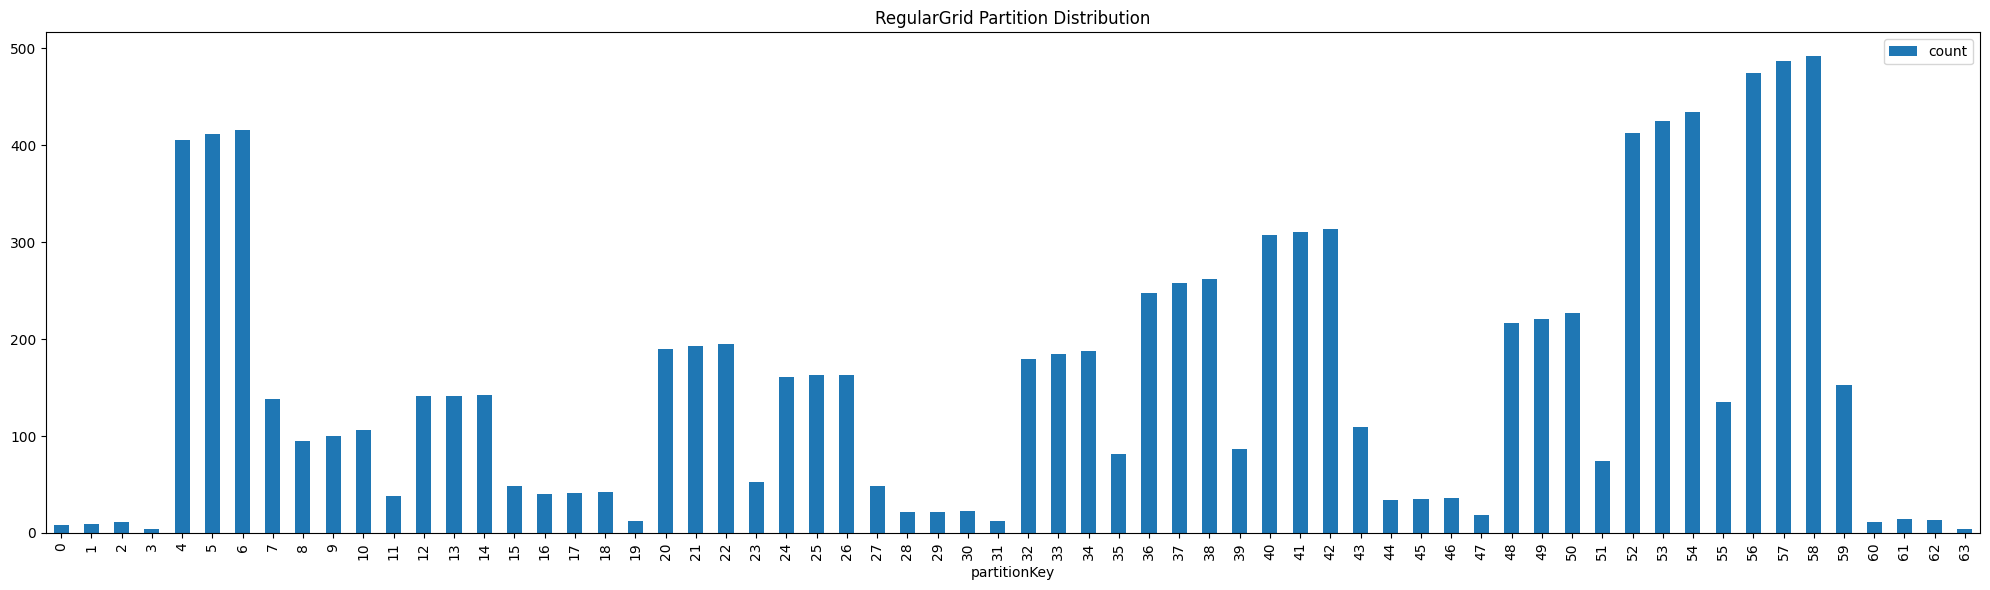

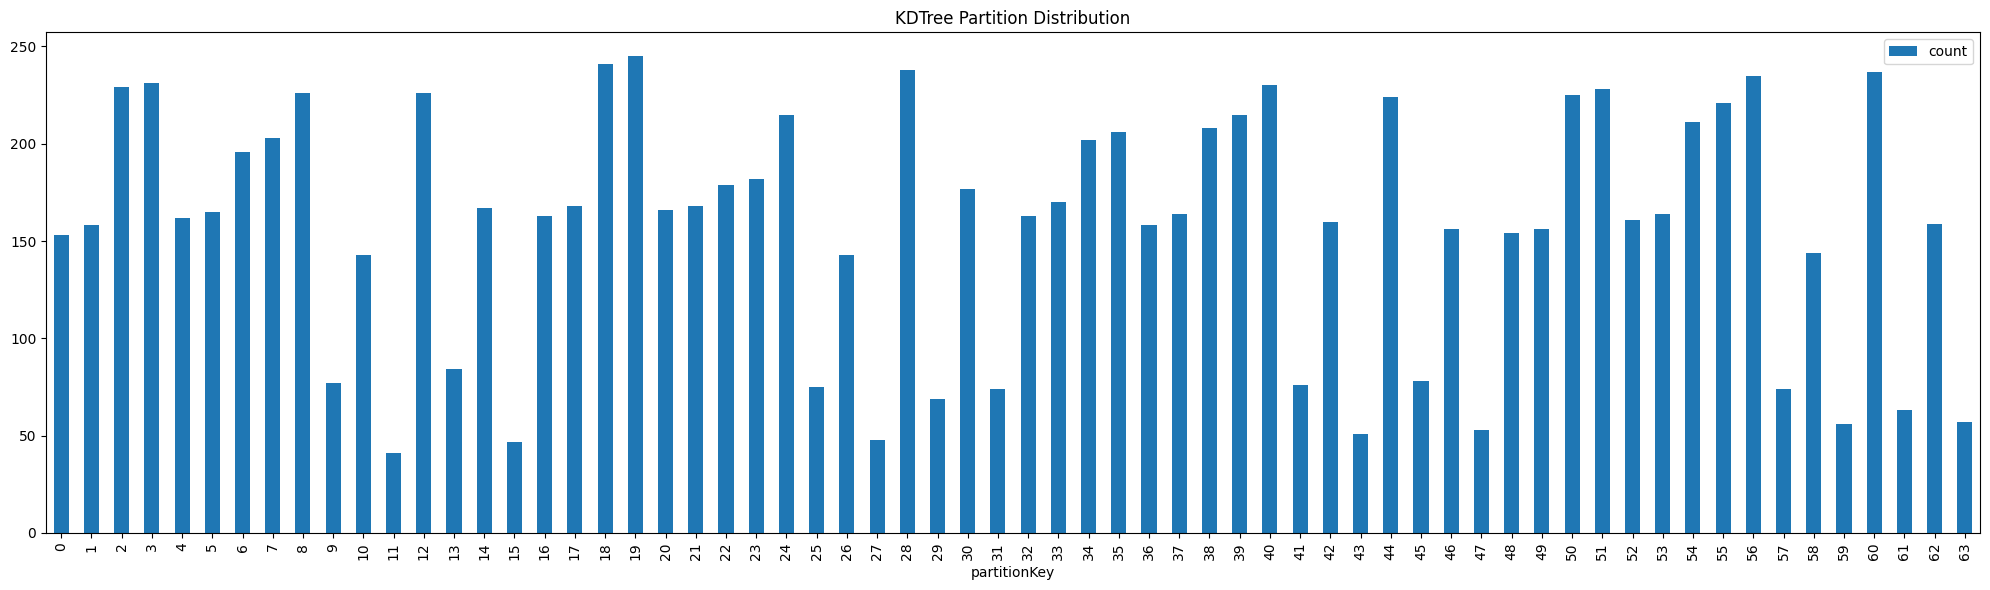

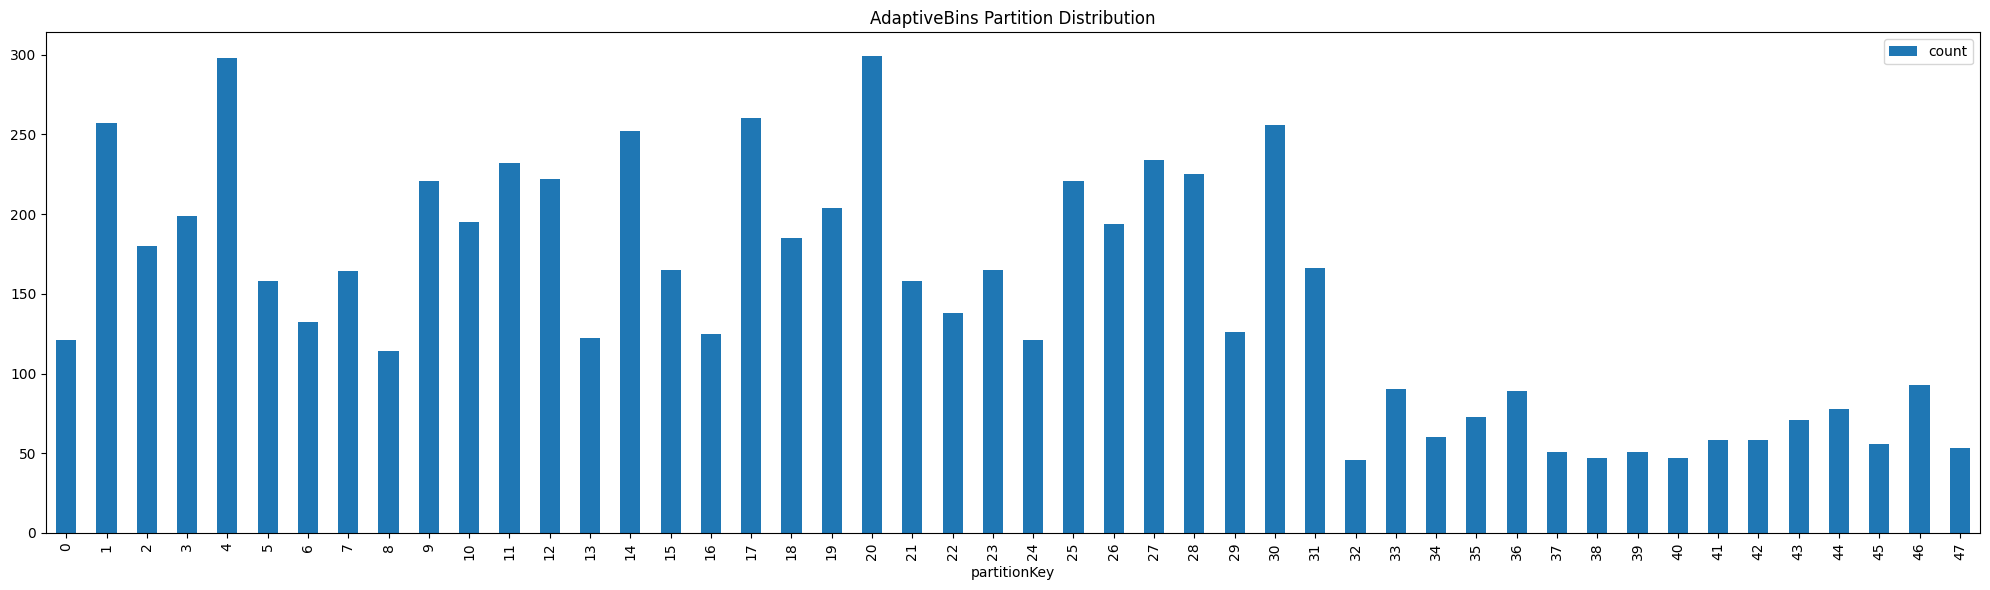

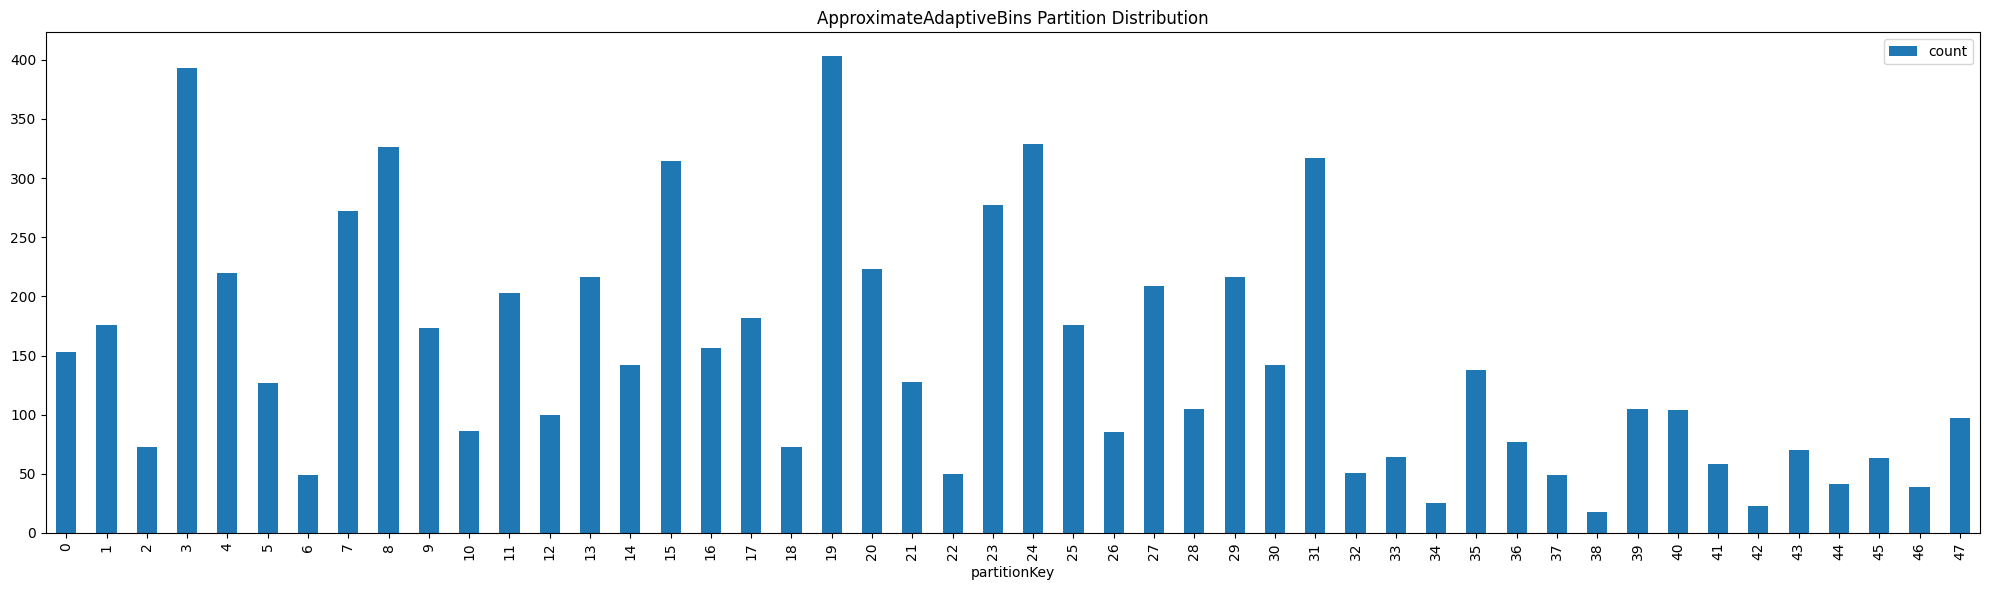

CPU times: user 24.4 s, sys: 7.58 s, total: 31.9 s
Wall time: 19min 57s


In [33]:
%%time

for trajectoriesPartMap, _, _, gridname in partMaps:
    print(f"{gridname} partition distribution.")
    
    trajectoriesPartMapCounts = trajectoriesPartMap.groupBy("partitionKey").count()

    # Convert the Spark DataFrame to a Pandas DataFrame
    pdf = trajectoriesPartMapCounts.toPandas()

    # Plot with modified figure size
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the width and height as needed
    pdf.plot.bar(x='partitionKey', y='count', ax=ax, title=f'{gridname} Partition Distribution')
    
    # Adjust layout and save fig
    fig.tight_layout()
    extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'distribution_{gridname}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

    stats = trajectoriesPartMapCounts.agg(
        F.mean(F.col("count")).alias("average_ppp"),
        F.stddev(F.col("count")).alias("stddev_ppp")
    )

    stats.show()
    
    trajectoriesPartRdd = trajectoriesPartMap.rdd
    print(trajectoriesPartRdd.getNumPartitions())
    
    # Function to count rows per partition
    def count_in_partition(idx, iterator):
        cnt = 0
        for _ in iterator:
            cnt += 1
        return [(idx, cnt)]
    
    # Using mapPartitionsWithIndex to count rows per partition
    partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
        
    # Print the results
    for partition_id, cnt in partition_counts:
        print(f"Partition {partition_id} has {cnt} rows")
    
    trajectoriesPartMap.show()

plt.show()

## Plot the Projection of the grid and the distribution of data

In [34]:
# Get a sample of the data to plot (for big datasets > 1000 trajectories)
seqIdRows = spark.sql("SELECT seqId AS seqId FROM trajectories TABLESAMPLE(50 ROWS)").collect()
#seqIdRows = spark.sql("SELECT seqId AS seqId FROM trajectories").collect()
seqIds = {row.seqId for row in seqIdRows}
print(len(seqIds))

50


/tmp/ipykernel_26143/3329810938.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


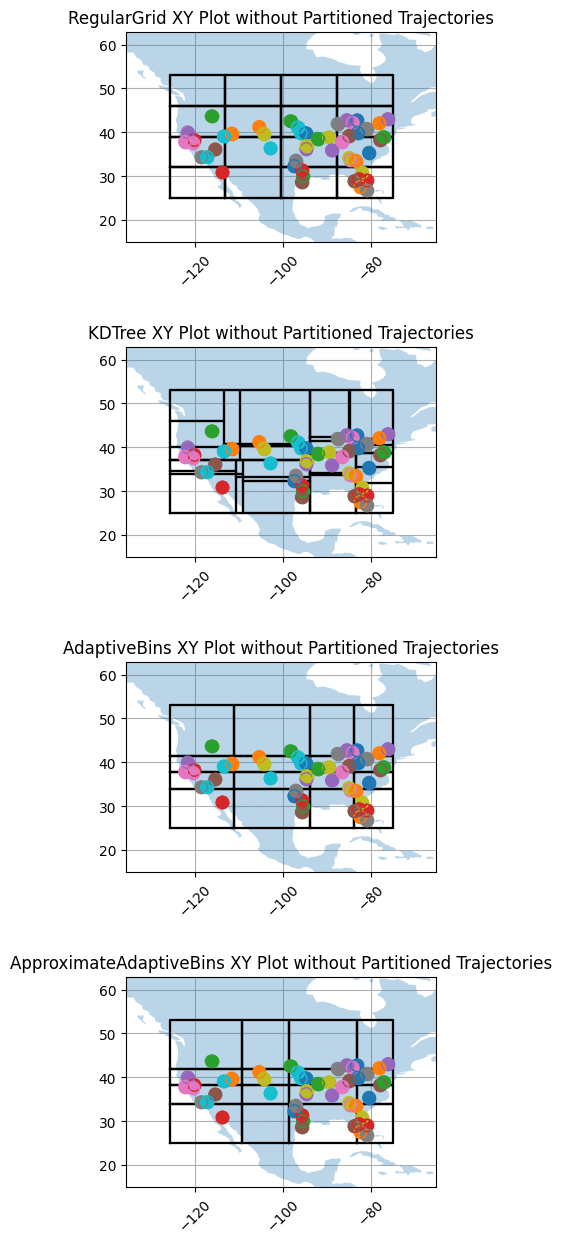

In [35]:
fig, ax = plt.subplots(len(partMaps), 1, figsize=(15, 15))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[world['continent'] == 'North America']

minx = bounds.expand(10.0).xmin()
maxx = bounds.expand(10.0).xmax()
miny = bounds.expand(10.0).ymin()
maxy = bounds.expand(10.0).ymax()

#for i in range(0, len(partMaps)*2, 2):
#    trajectoriesMap, partMapRdd, gridclass, gridname = partMaps[i]
#    j = i+1

fig.subplots_adjust(hspace=0.5)  # Increase the value to add more space

for i, (trajectoriesMap, partMapRdd, gridclass, gridname) in enumerate(partMaps):
    world.plot(ax=ax[i], alpha=0.3)
    #world.plot(ax=ax[j], alpha=0.3)

    gridclass.plot(axes=ax[i], color='black', draw_filling=False)
    #gridclass.plot(axes=ax[j], color='black', draw_filling=False)

    colors = plt.cm.Accent(np.linspace(0, 1, len(gridclass.tilesstr)))
    # Adding an alpha value when creating the color map
    alpha_value = 1.0
    color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, _ in enumerate(gridclass.tilesstr)}
    trajectory_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'lightgreen', 'darkblue']

    trajectory_idx = {}
    """
    for idx, row in enumerate(trajectoriesPartMap.where(trajectoriesPartMap.trajectoryId.isin(seqIds)).toLocalIterator()):
        if row.trajectoryId in trajectory_idx:
            c = trajectory_idx[row.trajectoryId]
        else:
            c = idx
            trajectory_idx[row.trajectoryId] = idx
        traj = row.trajectory
        TemporalPointSequenceSetPlotter.plot_xy(
            traj, axes=ax[j], show_markers=True, show_grid=True 
        )
    """
    for idx, row in enumerate(trajectories.where(trajectories.seqId.isin(seqIds)).toLocalIterator()):
        if row.icao24 in trajectory_idx:
            c = trajectory_idx[row.icao24]
        else:
            c = idx
            trajectory_idx[row.icao24] = idx
        TemporalPointSequencePlotter.plot_xy(
            row.PointSeq, axes=ax[i], show_markers=True, show_grid=True 
        )
    ax[i].set_xlim(minx, maxx)
    ax[i].set_ylim(miny, maxy)
    #ax[j].set_xlim(minx, maxx)
    #ax[j].set_ylim(miny, maxy)
    ax[i].title.set_text(f"{gridname} XY Plot without Partitioned Trajectories")
    #ax[j].title.set_text(f"{gridname} XY Plot with Partitioned Trajectories")

# Save each subplot as an SVG file with labels
for i, axis in enumerate(ax):
    extent = axis.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'dots_subplot_{i+1}.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.show()

In [149]:
from pymeos import Temporal, TSequenceSet

@F.udf(returnType=TsTzSpanUDT())
def tstzspan_from_values(lower, upper, utc="UTC"):
    pymeos_initialize(utc)
    span = None
    if lower >= upper:
        return None
    try: 
        span = TsTzSpan(lower=lower, upper=upper)
    except:
        pass
    return span

@F.udf(returnType=ArrayType(TimestampType()))
def timestamps(traj, utc="UTC"):
    pymeos_initialize(utc)
    return traj.timestamps()

@F.udf(returnType=ArrayType(FloatType()))
def spatial_values(traj, dim, utc='UTC'):
    pymeos_initialize(utc)
    if dim == 'x':
        return traj.x().values()
    if dim == 'y':
        return traj.y().values()
    if dim == 'z':
        return traj.z().values()

spark.udf.register("timestamps", timestamps)
spark.udf.register("spatial_values", spatial_values)
spark.udf.register("tstzspan_from_values", tstzspan_from_values)

In [154]:
dim = 'x'
ntiles = 4
dfname = 'trajectories'

dims_query = f"""
WITH 
Vals(dim) AS (
    SELECT explode(spatial_values(PointSeq, '{dim}'))
    FROM {dfname}
    ORDER BY 1 
),
MaxDimVals(MaxDim) AS (
    SELECT MAX(dim) 
    FROM Vals
),
Bins1(BinId, dim) AS (
    SELECT NTILE({ntiles}) OVER(ORDER BY dim), dim
    FROM Vals
),
Bins2(BinId, dim, RowNo) AS (
    SELECT BinId, dim, ROW_NUMBER() OVER (PARTITION BY BinId ORDER BY dim)
    FROM Bins1
)
SELECT 
    BinId, 
    RowNo, 
    dim, 
    LEAD(dim, 1) OVER(ORDER BY dim) AS ld, 
    tstzspan_from_values(dim, COALESCE(LEAD(dim, 1) OVER (ORDER BY dim), MaxDim)) AS span
FROM Bins2, MaxDimVals
WHERE RowNo = 1;
"""

spark.sql(dims_query).show(truncate=False)

24/07/06 07:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:36:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 0

+-----+-----+-------+------+----+
|BinId|RowNo|dim    |ld    |span|
+-----+-----+-------+------+----+
|1    |1    |-177.03|-97.89|NULL|
|2    |1    |-97.89 |-82.47|NULL|
|3    |1    |-82.47 |0.82  |NULL|
|4    |1    |0.82   |NULL  |NULL|
+-----+-----+-------+------+----+



In [157]:
spark.sql(f"""
WITH 
Times(T) AS (
    SELECT explode(timestamps(PointSeq))
    FROM trajectories
    ORDER BY 1 
),
MaxTime(MaxT) AS (
    SELECT MAX(T) 
    FROM Times 
),
Bins1(BinId, T) AS (
    SELECT NTILE({ntiles}) OVER(ORDER BY T), T
    FROM Times 
),
Bins2(BinId, T, RowNo) AS (
    SELECT BinId, T, ROW_NUMBER() OVER (PARTITION BY BinId ORDER BY T)
    FROM Bins1
)
SELECT 
    BinId, 
    T, 
    LEAD(T, 1) OVER(ORDER BY T) AS ld, 
    tstzspan_from_values(T, COALESCE(LEAD(T, 1) OVER (ORDER BY T), MaxT)) AS span
FROM Bins2, MaxTime
WHERE RowNo = 1;
""").show(truncate=False)

24/07/06 07:39:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:39:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:39:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:39:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:39:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 07:39:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 0

+-----+-------------------+-------------------+------------------------------------------------+
|BinId|T                  |ld                 |span                                            |
+-----+-------------------+-------------------+------------------------------------------------+
|1    |2022-06-27 00:00:00|2022-06-27 00:00:20|[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00)|
|2    |2022-06-27 00:00:20|2022-06-27 00:00:30|[2022-06-27 00:00:20+00, 2022-06-27 00:00:30+00)|
|3    |2022-06-27 00:00:30|2022-06-27 00:00:40|[2022-06-27 00:00:30+00, 2022-06-27 00:00:40+00)|
|4    |2022-06-27 00:00:40|NULL               |[2022-06-27 00:00:40+00, 2022-06-27 00:00:50+00)|
+-----+-------------------+-------------------+------------------------------------------------+



24/07/06 09:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 09:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 09:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 09:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 09:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 09:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/06 0

+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|tileid|tile                                                                                                                                       |
+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|0     |STBOX XT(((-177.03,-46.42),(-97.88999938964844,32.939998626708984)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00])                      |
|1     |STBOX XT(((-97.88999938964844,-46.42),(-82.47000122070312,32.939998626708984)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00])           |
|2     |STBOX XT(((-82.47000122070312,-46.42),(0.819999992847443,32.939998626708984)),[2022-06-27 00:00:00+00, 2022-06-27 00:00:20+00])            |
|3     |STBOX XT(((0.819999992847443,-46.42),(177.4,32.939998626708984)),[2022-06-27 00:00:00+00, 2022-06-

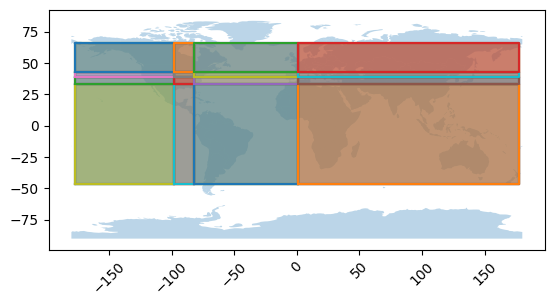

In [172]:
import math

from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.mobility_partitioner import MobilityPartitioner
from pysparkmeos.utils.utils import new_bounds_from_axis, from_axis, new_bounds
from typing import *
from pymeos import *
from pymeos import TPoint
import numpy as np
import pandas as pd
import itertools


class AdaptiveBinsPartitionerSpark(MobilityPartitioner):
    def __init__(
            self,
            spark,
            bounds,
            df,
            num_tiles,
            dimensions=["x", "y", "t"],
            utc="UTC"
    ):
        self.grid = [
            tile for tile in self._generate_grid(
                spark, bounds, df, num_tiles, dimensions, utc
            )
        ]
        self.tilesstr = [tile.__str__() for tile in self.grid]
        self.numPartitions = len(self.tilesstr)
        super().__init__(self.numPartitions, self.get_partition)


    @staticmethod
    def _generate_grid(
            spark,
            bounds: STBox,
            df,
            num_tiles: int,
            dimensions = ["x", "y", "t"],
            utc: str = "UTC"
    ):
        pymeos_initialize(utc)

        unchecked_dims = dimensions
        new_tiles = {}
        while(unchecked_dims):
            cur_dim = unchecked_dims.pop()
            new_tiles[cur_dim] = AdaptiveBinsPartitionerSpark._generate_grid_dim(spark, bounds, df, cur_dim, num_tiles, utc)

        tiles = []
        for combination in itertools.product(*new_tiles.values()):
            combination_dict = dict(zip(new_tiles.keys(), combination))
            intersection_box = None
            for dim, box in combination_dict.items():
                if not intersection_box:
                    intersection_box = box
                else:
                    intersection_box = intersection_box.intersection(box)
            if intersection_box:
                tiles.append(intersection_box)
        return tiles

    @staticmethod
    def _generate_grid_dim(
            spark,
            bounds: STBox,
            df,
            dim: str,
            num_tiles: int,
            utc: str
    ):
        pymeos_initialize(utc)
        ntiles = 4
        
        df.createOrReplaceTempView('trajectories')

        dims_query = f"""
        WITH 
        Vals(dim) AS (
            SELECT explode(spatial_values(PointSeq, '{dim}'))
            FROM trajectories
            ORDER BY 1 
        ),
        MaxDimVals(MaxDim) AS (
            SELECT MAX(dim) 
            FROM Vals
        ),
        Bins1(BinId, dim) AS (
            SELECT NTILE({ntiles}) OVER(ORDER BY dim), dim
            FROM Vals
        ),
        Bins2(BinId, dim, RowNo) AS (
            SELECT BinId, dim, ROW_NUMBER() OVER (PARTITION BY BinId ORDER BY dim)
            FROM Bins1
        )
        SELECT 
            BinId, 
            RowNo, 
            dim AS minbound,
            LEAD(dim, 1) OVER(ORDER BY dim) AS maxbound
        FROM Bins2, MaxDimVals
        WHERE RowNo = 1;
        """
        if dim == 't':
            dims_query = f"""
                WITH 
                Times(T) AS (
                    SELECT explode(timestamps(PointSeq))
                    FROM trajectories
                    ORDER BY 1 
                ),
                MaxTime(MaxT) AS (
                    SELECT MAX(T) 
                    FROM Times 
                ),
                Bins1(BinId, T) AS (
                    SELECT NTILE({ntiles}) OVER(ORDER BY T), T
                    FROM Times 
                ),
                Bins2(BinId, T, RowNo) AS (
                    SELECT BinId, T, ROW_NUMBER() OVER (PARTITION BY BinId ORDER BY T)
                    FROM Bins1
                )
                SELECT 
                    BinId, 
                    T AS minbound, 
                    LEAD(T, 1) OVER(ORDER BY T) AS maxbound
                FROM Bins2, MaxTime
                WHERE RowNo = 1;
            """
        binrows = spark.sql(dims_query).collect()
        tiles = []
        for i, row in enumerate(binrows):
            minbound = row.minbound
            maxbound = row.maxbound
            if i == 0:
                if dim == 'x':
                    minbound = min(bounds.xmin(), row.minbound)
                if dim == 'y':
                    minbound = min(bounds.ymin(), row.minbound)
                if dim == 'z':
                    minbound = min(bounds.zmin(), row.minbound)
                if dim == 't':
                    minbound = row.minbound.replace(tzinfo=bounds.tmin().tzinfo)
                    minbound = min(bounds.tmin(), minbound)
            if i == len(binrows)-1:
                if dim == 'x':
                    maxbound = bounds.xmax()
                if dim == 'y':
                    maxbound = bounds.ymax()
                if dim == 'z':
                    maxbound = bounds.zmax()
                if dim == 't':
                    maxbound = bounds.tmax()
            tiles.append(STBoxWrap(new_bounds(bounds, dim, minbound, maxbound).__str__()))
        return tiles

    def num_partitions(self) -> int:
        """Return the total number of partitions."""
        return self.numPartitions

sabp = SparkAdaptiveBinsPartitioner(spark, bounds, trajectories, 4)
world.plot(alpha=0.3)
sabp.as_spark_table().show(truncate=False)
sabp.plot()